# PubMed 200k RCT: Dataset for Sequential Sentence Classification

**Main model architecture:** https://arxiv.org/pdf/1612.05251.pdf

In [1]:
# Importing modules
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import random
import string

# Custom
from helper_function.niffo_helper import calculate_result
from helper_function import niffo_plotter, preprocessing

## Getting Data Ready
**Link:** https://github.com/Franck-Dernoncourt/pubmed-rct

`!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git`

In [2]:
# Using 20k dataset for the initial model
data_dir = "Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

### Preprocessing Data

In [3]:
train_data = preprocessing.get_raw_data(data_dir + "train.txt")
val_data = preprocessing.get_raw_data(data_dir + "dev.txt")
test_data = preprocessing.get_raw_data(data_dir + "test.txt")

In [4]:
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [5]:
train_data[0]

{'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'line_number': 0,
 'total_lines': 11}

### Making pandas DataFrame

In [6]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [7]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [8]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [9]:
val_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


### Getting the sentences

In [10]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()

In [11]:
train_sen[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### Making numerical labels

In [12]:
ohe = OneHotEncoder(sparse=False)
train_labels = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
test_labels = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
val_labels = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))

In [13]:
tf.constant(train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Encoding labels

In [14]:
label_encoder = LabelEncoder()
etrain_labels = label_encoder.fit_transform(train_df["target"].to_numpy())
etest_labels = label_encoder.fit_transform(test_df["target"].to_numpy())
eval_labels = label_encoder.fit_transform(val_df["target"].to_numpy())

In [15]:
etrain_labels, etest_labels, eval_labels

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]))

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0: BaseLine model

(TF-IDF Multinomial Naive Bayes Classifier).

**Score:**

`accuracy': 71.66%`

`precision': 0.7124322482375202`

`recall': 0.716674962667994,`

`f1-score': 0.6925101703856846`

In [17]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])
model_0.fit(train_sen, etrain_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
model_0.score(val_sen, eval_labels)

0.7218323844829869

In [19]:
model_0_preds = model_0.predict(test_sen)

In [20]:
model_0_res = calculate_result(y_true=etest_labels, y_predict=model_0_preds)
model_0_res

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1-score': 0.6925101703856846}

In [72]:
mat_class = [i[0] + i[1:].lower() for i in class_names]

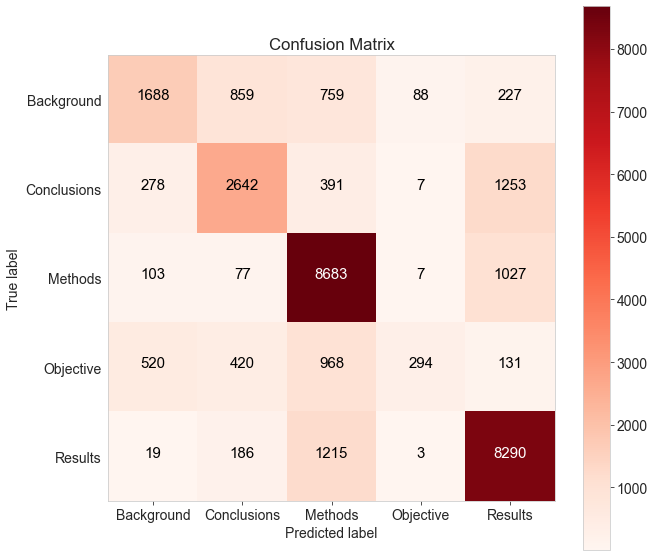

In [73]:
niffo_plotter.plot_confusion_matrix(y_true=etest_labels, y_predict=model_0_preds, classes=mat_class)

## Model 1: Convolutional 1-D model
(Conv1D with token embeddings)

**Score:**

`accuracy': 78.52%`

`precision': 0.7817069791201003`

`recall': 0.7852663016426082`
 
`f1-score': 0.782223028043873`

In [22]:
sen_len = [len(sen.split()) for sen in train_sen]
np.mean(sen_len)

26.338269273494777

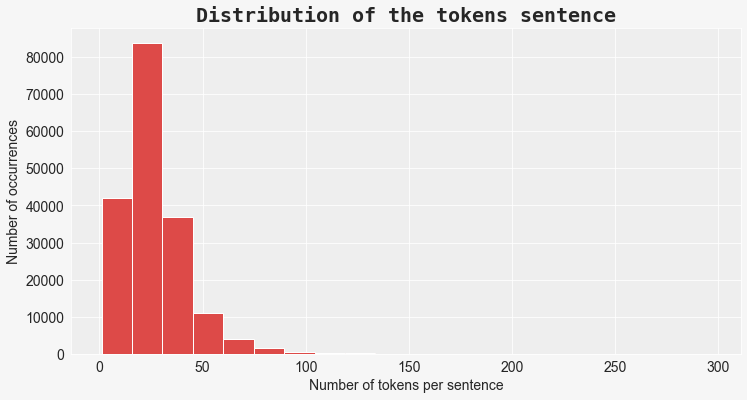

In [23]:
niffo_plotter.plot_histogram(data=sen_len,
                             xlabel="Number of tokens per sentence",
                             ylabel="Number of occurrences",
                             title="Distribution of the tokens sentence",
                             bins=20)

In [24]:
# The graph represents taking 95% of the data is safe for the sequences length output
out_seq_len = int(np.percentile(sen_len, 95))
out_seq_len

55

In [25]:
max(sen_len) # Outlier

296

### Creating text vector and embedding layer

In [26]:
# Preparing text vector
text_vector = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                          output_sequence_length=out_seq_len)
text_vector.adapt(train_sen)

In [27]:
embed = tf.keras.layers.Embedding(input_dim=68000,
                                 output_dim=128,
                                 input_length=out_seq_len)

In [28]:
text_vector(["checking if it is working"])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[61684,   324,   185,    20,  1615,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

### Creating datasets for loading the data efficiently

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [30]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Preparing convolutional model architecture

In [31]:
# Input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Text Vectorization
x = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=68000,
                                                                output_sequence_length=55)
x.adapt(train_sen)

# Apply text vectorization on inputs
x = x(inputs)

# Adding Embedding layer
x = tf.keras.layers.Embedding(input_dim=68000,
                             output_dim=128,
                             input_length=55)(x)
# Adding Conv1D layer
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           activation="relu",
                           name="conv1D_layer",
                           padding="same")(x)
# Applying pooling layer
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Adding output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining into model_1
model_1 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [32]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8704000   
                                                                 
 conv1D_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [33]:
# Fitting the data into the model
his_1 = model_1.fit(train_dataset,
            epochs=5,
            validation_data=valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 68s 11ms/step - loss: 0.6136 - accuracy: 0.7765 - val_loss: 0.5337 - val_accuracy: 0.8101
Epoch 2/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.4495 - accuracy: 0.8423 - val_loss: 0.5334 - val_accuracy: 0.8114
Epoch 3/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3686 - accuracy: 0.8737 - val_loss: 0.5677 - val_accuracy: 0.8072
Epoch 4/5
5627/5627 [==============================] - 62s 11ms/step - loss: 0.3041 - accuracy: 0.8984 - val_loss: 0.6296 - val_accuracy: 0.8009
Epoch 5/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.2507 - accuracy: 0.9188 - val_loss: 0.7079 - val_accuracy: 0.7929


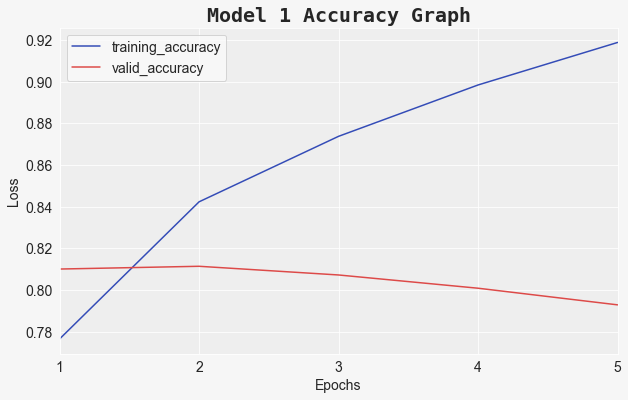

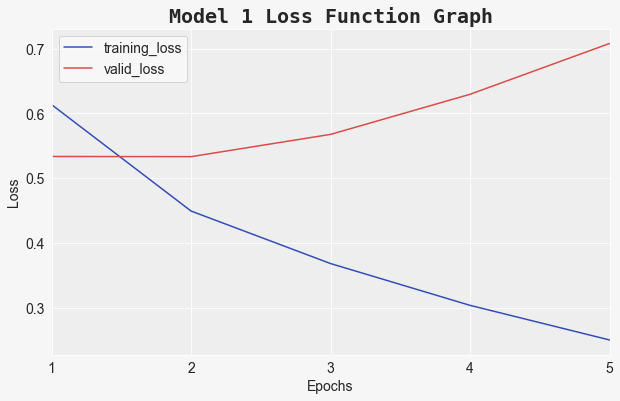

In [34]:
niffo_plotter.plot_model_history_accuracy(his_1, model_name="Model 1")
niffo_plotter.plot_model_history_loss(his_1, model_name="Model 1")

In [35]:
# Predicting test data
model_1_preds = model_1.predict(test_dataset)
model_1_preds

array([[5.35819709e-01, 1.03389464e-01, 3.92897725e-02, 2.04866871e-01,
        1.16634168e-01],
       [2.25941651e-03, 1.21286092e-03, 3.59162271e-01, 5.16358647e-04,
        6.36849105e-01],
       [6.31934381e-05, 1.84071600e-04, 9.39315915e-01, 6.81868914e-05,
        6.03686012e-02],
       ...,
       [9.41214967e-06, 4.88376012e-03, 1.00489357e-04, 4.49020126e-06,
        9.95001853e-01],
       [5.29563869e-04, 6.78342953e-03, 1.67481054e-03, 1.17882875e-04,
        9.90894318e-01],
       [1.03900430e-03, 4.44427356e-02, 1.98616385e-02, 1.66371847e-05,
        9.34639990e-01]], dtype=float32)

In [36]:
model_1_preds = np.argmax(model_1_preds, axis=1)
model_1_preds

array([0, 4, 2, ..., 4, 4, 4], dtype=int64)

In [37]:
calculate_result(y_true=etest_labels, y_predict=model_1_preds)

{'accuracy': 78.41712294673967,
 'precision': 0.7796231919574803,
 'recall': 0.7841712294673967,
 'f1-score': 0.7810718064918462}

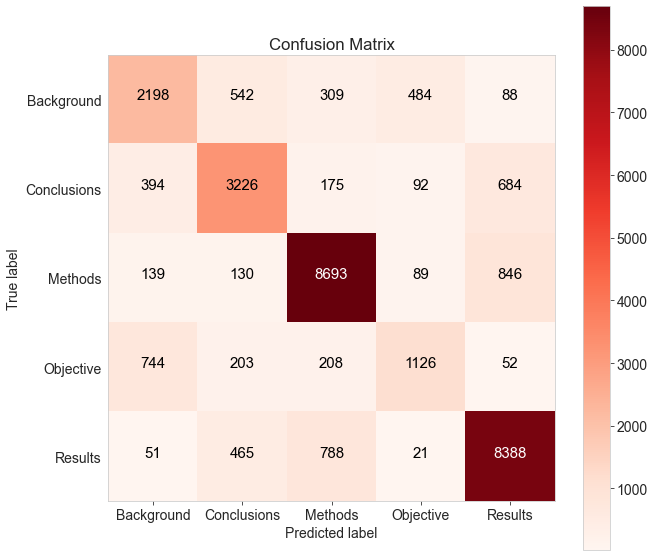

In [74]:
make_confusion_matrix(y_true=etest_labels, y_pred=model_1_preds, classes=mat_class)

## Model 2: Transfer learning Feature Extraction model

Pretrained embedding layer link - https://tfhub.dev/google/universal-sentence-encoder/4

**Score:**

`accuracy: 76.76455948232952%`

`precision: 0.7651474813371973`

`recall: 0.7676455948232952`

`f1-score: 0.763595417021131`

In [38]:
pretrained_dir = "Pretrained/universal-sentence-encoder_4" # or Pretrained embedding layer link

In [39]:
# Loading embedding layer
embedding_layer = hub.KerasLayer(pretrained_dir, trainable=False, name="universal_sentence_encoder")

In [40]:
# Testing embedding layer
sen = random.choice(train_sen)
print(f"Choosen sentence:\n{sen}")
embedded_sen = embedding_layer([sen])
print(f"\nApplied embedding layer:\n{embedded_sen[0][:24]}\n\nShape: {embedded_sen.shape}")

Choosen sentence:
anticoagulation prophylaxis for stroke is recommended for at-risk patients with either persistent or paroxysmal atrial fibrillation ( af ) .

Applied embedding layer:
[-1.8158881e-02  3.8850997e-02 -2.9905623e-02 -2.6868459e-02
 -5.9622485e-02  5.5093729e-05  4.2254090e-02 -7.3375896e-02
 -1.7124359e-02  4.6889186e-02  8.6560912e-02 -3.2247347e-03
  1.2740331e-02  3.8464628e-02 -1.4239375e-03 -4.6471036e-03
 -8.6822107e-02 -6.6836633e-02 -4.3287396e-02  3.9127249e-02
  7.9836100e-02  6.7983404e-02 -3.4378383e-02 -3.6314126e-02]

Shape: (1, 512)


In [41]:
# Creating input layer
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")

# Passing inputs to the embedding layer
x = embedding_layer(inputs)

# adding layers
x = tf.keras.layers.Dense(128, activation="relu")(x)

# Creating output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining inputs and outputs
model_2 = tf.keras.Model(inputs, outputs, name="output_layer")


# Compiling the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [42]:
model_2.summary()

Model: "output_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [43]:
# Fitting the train and validation data
his_2 = model_2.fit(train_dataset,
                    epochs=5,
                    validation_data=valid_dataset)

Epoch 1/5
5627/5627 [==============================] - 94s 16ms/step - loss: 0.7290 - accuracy: 0.7207 - val_loss: 0.6573 - val_accuracy: 0.7484
Epoch 2/5
5627/5627 [==============================] - 91s 16ms/step - loss: 0.6362 - accuracy: 0.7585 - val_loss: 0.6227 - val_accuracy: 0.7612
Epoch 3/5
5627/5627 [==============================] - 91s 16ms/step - loss: 0.6021 - accuracy: 0.7730 - val_loss: 0.6069 - val_accuracy: 0.7673
Epoch 4/5
5627/5627 [==============================] - 90s 16ms/step - loss: 0.5791 - accuracy: 0.7817 - val_loss: 0.5981 - val_accuracy: 0.7728
Epoch 5/5
5627/5627 [==============================] - 90s 16ms/step - loss: 0.5619 - accuracy: 0.7885 - val_loss: 0.5954 - val_accuracy: 0.7742


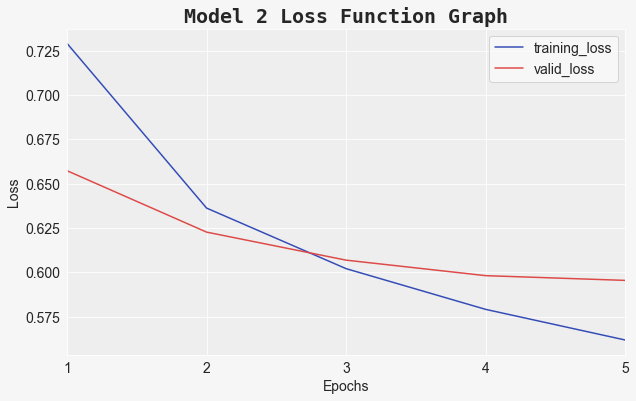

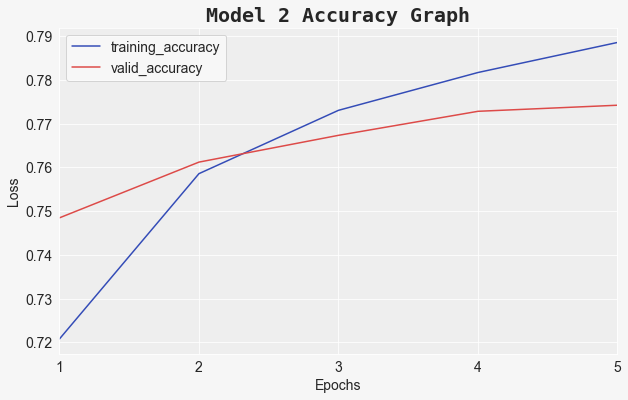

In [44]:
niffo_plotter.plot_model_history_loss(his_2, model_name="Model 2")
niffo_plotter.plot_model_history_accuracy(his_2, model_name="Model 2")

In [45]:
model_2_preds = tf.argmax(model_2.predict(test_dataset), axis=1)
calculate_result(y_true=etest_labels, y_predict=model_2_preds)

{'accuracy': 76.43603782976605,
 'precision': 0.7615142874274943,
 'recall': 0.7643603782976606,
 'f1-score': 0.7606163683151624}

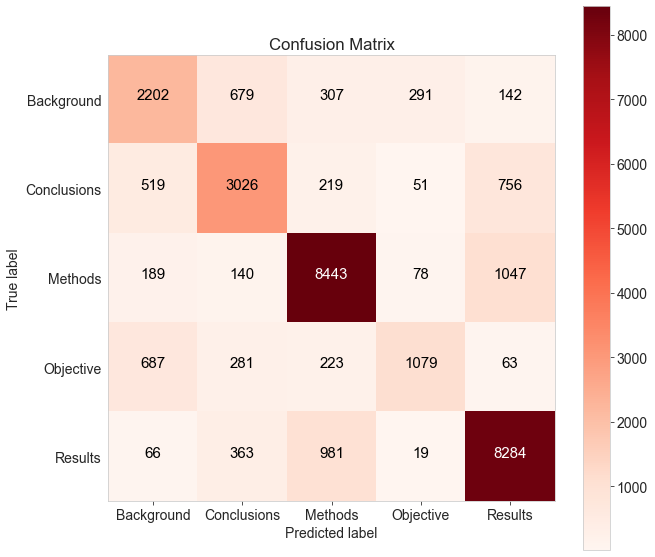

In [75]:
make_confusion_matrix(y_true=etest_labels, y_pred=model_2_preds, classes=mat_class)

## Model 3: Convolutional 1-D with Character embeddings

**Score:**

`accuracy: 73.48%`

`precision: 0.7333355362987595`

`recall: 0.7347270615563298`

`f1-score: 0.7283699804820812`


In [46]:
train_chars = [preprocessing.split_chars(sen) for sen in train_sen]
val_chars = [preprocessing.split_chars(sen) for sen in val_sen]
test_chars = [preprocessing.split_chars(sen) for sen in test_sen]

In [47]:
train_chars[:2][:20]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [48]:
# figuring out output sequence length
char_lens = [float(len(sen)) for sen in train_sen]
tf.reduce_mean(char_lens)

<tf.Tensor: shape=(), dtype=float32, numpy=149.36626>

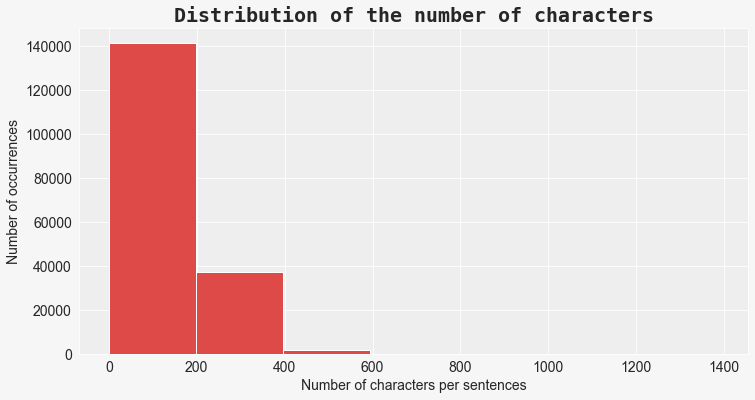

In [49]:
# Checking the distribution of the characters
niffo_plotter.plot_histogram(char_lens, bins=7, xlabel="Number of characters per sentences",
                            ylabel="Number of occurrences",
                            title="Distribution of the number of characters")

In [50]:
# Finding character length that covers 95% of the sequences
os_length = int(np.percentile(char_lens, 95))
os_length

290

### Building model

In [51]:
# Creating input layer
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")

# Creating text vectorization layer
x = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=70,
                                                                output_sequence_length=os_length)
x.adapt(train_chars)

char_vocab = x.get_vocabulary()

# Adding text vectorization layer to the model
x = x(inputs)

# Adding embedding layer
x = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                             output_dim=25,
                             mask_zero=False,
                             name="character_embedding_layer")(x)
# Adding Convulational layers
x = tf.keras.layers.Conv1D(filters=64,
                          kernel_size=5,
                          activation="relu",
                           padding="same",
                          name="convulational_layer_1D")(x)
# Adding pooling layer
x = tf.keras.layers.GlobalMaxPool1D(name="pooling_layer")(x)

# Creating output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combining inputs and outputs
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

# Compiling model 3
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [52]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 character_embedding_layer (  (None, 290, 25)          700       
 Embedding)                                                      
                                                                 
 convulational_layer_1D (Con  (None, 290, 64)          8064      
 v1D)                                                            
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 64)               0         
 ling1D)                                                   

In [53]:
# Creating character datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [55]:
# Fitting data
his_3 = model_3.fit(train_char_dataset, epochs=5, validation_data=val_char_dataset)

Epoch 1/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.9111 - accuracy: 0.6402 - val_loss: 0.7991 - val_accuracy: 0.6863
Epoch 2/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.7566 - accuracy: 0.7104 - val_loss: 0.7528 - val_accuracy: 0.7090
Epoch 3/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.7147 - accuracy: 0.7302 - val_loss: 0.7148 - val_accuracy: 0.7287
Epoch 4/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.6909 - accuracy: 0.7401 - val_loss: 0.6971 - val_accuracy: 0.7353
Epoch 5/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.6771 - accuracy: 0.7456 - val_loss: 0.6866 - val_accuracy: 0.7410


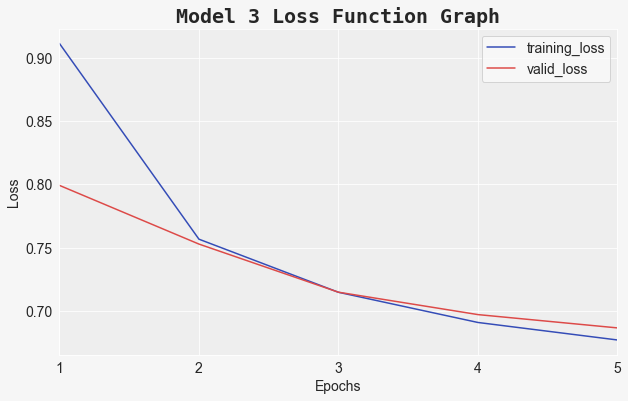

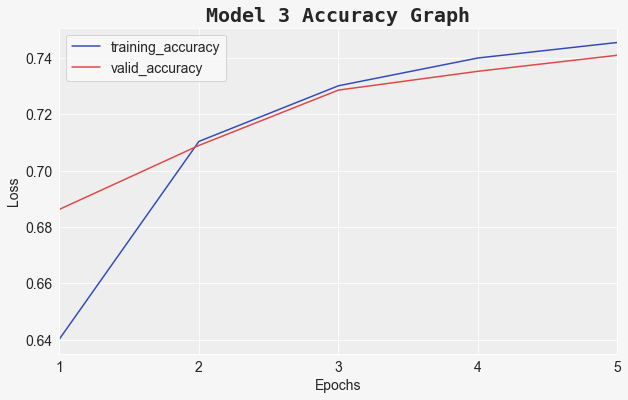

In [56]:
niffo_plotter.plot_model_history_loss(his_3, model_name="Model 3")
niffo_plotter.plot_model_history_accuracy(his_3, model_name="Model 3")

In [57]:
model_3_preds = tf.argmax(model_3.predict(test_char_dataset), axis=1)
calculate_result(y_true=etest_labels, y_predict=model_3_preds)

{'accuracy': 73.4428405508545,
 'precision': 0.7342428692443401,
 'recall': 0.7344284055085449,
 'f1-score': 0.7290209382196349}

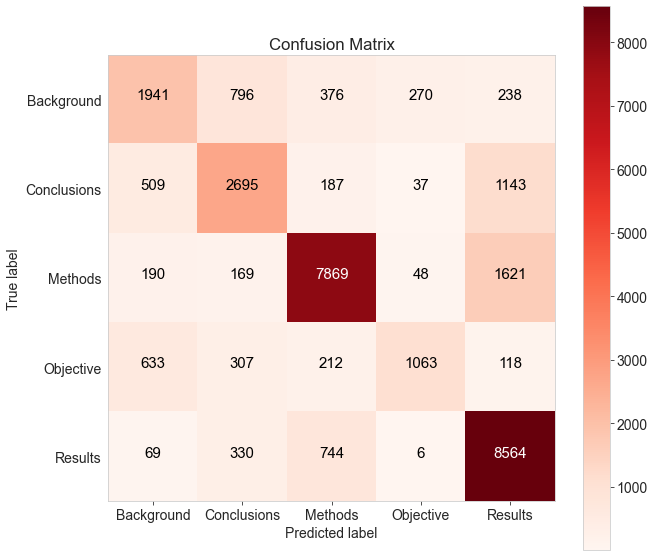

In [76]:
make_confusion_matrix(y_true=etest_labels, y_pred=model_3_preds, classes=mat_class)

## Model 4: Combined Pretrained token Embedding and Character Embedding Model